## 1) Load helper extractor class to process data for London only

In [1]:
from src.LondonExtractor import LondonFilter

In [2]:
filterer = LondonFilter(input_dir="./data/", output_path="./data/london.csv")
filterer.process()

Filtered London data saved to: ./data/london.csv


## 2) Read in London dataset

In [3]:
import pandas as pd

In [4]:
london_df = pd.read_csv("./data/london.csv")

In [5]:
# Convert to datetime
london_df['transfer_date'] = pd.to_datetime(london_df['transfer_date'], errors='coerce')

# Extract year
london_df['year'] = london_df['transfer_date'].dt.year

# Extract month
london_df['month'] = london_df['transfer_date'].dt.month

# Value counts by year
london_df['year'].value_counts().sort_index()


year
2018    67138
2019    64677
2020    59624
2021    85207
2022    75127
2023    58875
2024    57204
2025    16270
Name: count, dtype: int64

In [6]:
london_df

,transaction_id,price,transfer_date,postcode,property_type,old_new,duration,paon,saon,street,locality,town,district,county,ppd_category,record_status,year
0,{75050A85-94A5-9A88-E053-6B04A8C02390},545000,2018-08-24,SW17 0PS,T,N,F,137,NaN,STRATHDON DRIVE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2018
1,{75050A85-94A9-9A88-E053-6B04A8C02390},480000,2018-07-06,SW2 3TP,F,N,L,64,NaN,WYATT PARK ROAD,NaN,LONDON,LAMBETH,GREATER LONDON,A,A,2018
2,{75050A85-94AD-9A88-E053-6B04A8C02390},415000,2018-08-13,SW14 7LR,F,N,L,HUNTINGDON COURT,FLAT 12,LITTLE ST LEONARDS,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,2018
3,{75050A85-94AE-9A88-E053-6B04A8C02390},2765000,2018-07-18,SW15 6AL,D,N,F,57,NaN,ST JOHNS AVENUE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2018
4,{75050A85-94B2-9A88-E053-6B04A8C02390},750000,2018-08-07,SW17 0NP,T,N,F,694,NaN,GARRATT LANE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484117,{38EDC0C3-613C-0F63-E063-4704A8C00424},446000,2025-05-02,SW12 8NY,F,N,L,56,FLAT 1,NIGHTINGALE LANE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2025
484118,{38EDC0C3-613D-0F63-E063-4704A8C00424},380000,2025-05-16,E15 2GB,F,N,L,"OPAL COURT, 172",76,HIGH STREET,STRATFORD,LONDON,NEWHAM,GREATER LONDON,A,A,2025
484119,{38EDC0C3-613E-0F63-E063-4704A8C00424},500000,2025-03-31,SE23 1BF,S,N,F,4,NaN,BEAUMARIS MEWS,NaN,LONDON,LEWISHAM,GREATER LONDON,A,A,2025
484120,{38EDC0C3-613F-0F63-E063-4704A8C00424},685000,2025-05-22,SW4 8BQ,F,N,L,36,FLAT 2,KINGS AVENUE,NaN,LONDON,LAMBETH,GREATER LONDON,A,A,2025


In [7]:
print(f'There are {len(london_df['postcode'].unique())} unique postcodes in the dataset')

There are 72997 unique postcodes in the dataset


## 3) Exploratory Data Analysis

### 3.1) Transaction volume per month

In [8]:
import plotly.express as px

# Ensure the transfer_date is in datetime format
london_df['transfer_date'] = pd.to_datetime(london_df['transfer_date'], errors='coerce')

# Create a new column for month-year (use first day of month for consistency)
london_df['month_year'] = london_df['transfer_date'].dt.to_period('M').dt.to_timestamp()

# Aggregate by month-year and count the number of transactions
monthly_counts = london_df.groupby('month_year').size().reset_index(name='transaction_count')

# Plot with Plotly Express
fig = px.line(
    monthly_counts,
    x='month_year',
    y='transaction_count',
    title='Monthly Transaction Volume in London',
    labels={'month_year': 'Month-Year', 'transaction_count': 'Number of Transactions'}
)

# Customize layout
fig.update_layout(xaxis=dict(tickformat='%b %Y'), title_x=0.5)

fig.show()


### 3.2) MoM % change in transactions

In [9]:
# Aggregate by month and count transactions
monthly_counts = london_df.groupby('month_year').size().reset_index(name='transaction_count')

# Calculate MoM % change
monthly_counts['mom_percent_change'] = monthly_counts['transaction_count'].pct_change() * 100

# Plot MoM % change
fig = px.line(
    monthly_counts,
    x='month_year',
    y='mom_percent_change',
    title='Month-over-Month % Change in Transactions',
    labels={'month_year': 'Month-Year', 'mom_percent_change': 'MoM % Change'},
    markers=True
)

# Add zero line and format
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(xaxis=dict(tickformat='%b %Y'), title_x=0.5)

fig.show()


### 3.3) Average prices over time

In [10]:
london_df['month_year'] = london_df['transfer_date'].dt.to_period('M').dt.to_timestamp()

# Group by month and compute average price
monthly_avg = (
    london_df
    .groupby('month_year', as_index=False)['price']
    .mean()
    .rename(columns={'price': 'avg_price'})
)

# Plot using Plotly Express
fig = px.line(
    monthly_avg,
    x='month_year',
    y='avg_price',
    title='Monthly Average Property Price in London',
    labels={'month_year': 'Month-Year', 'avg_price': 'Average Price (£)'},
    markers=True
)

fig.update_layout(
    xaxis=dict(tickformat='%b %Y'),
    title_x=0.5,
    yaxis_tickprefix='£'
)

fig.show()

### 3.4) MoM % change in average prices

In [11]:
monthly_avg['mom_pct_change'] = monthly_avg['avg_price'].pct_change() * 100

# Plot MoM % change using Plotly Express
fig = px.line(
    monthly_avg,
    x='month_year',
    y='mom_pct_change',
    title='Month-over-Month % Change in Average Price (London)',
    labels={'month_year': 'Month-Year', 'mom_pct_change': 'MoM % Change in Avg Price'},
    markers=True
)

# add a zero reference line and formatting
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(
    xaxis=dict(tickformat='%b %Y'),
    title_x=0.5,
    yaxis_tickformat='.1f%'
)

fig.show()

### 3.5) Mapping

In [12]:
# Import custom mapping utils
from src.MappingUtils import *

In [13]:
# Load the shapefile 
shapefile_path = "./assets/CodePointOpen_London_201709.shx"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs(epsg=27700)


In [14]:
# Add yearly transactions to shapefile
gdf = add_transaction_columns_to_gdf(gdf,london_df)

In [15]:
# Create a Hexgrid to perform hexbinning over post code units
hexes = generate_hexgrid(gdf, hex_size = 1000)

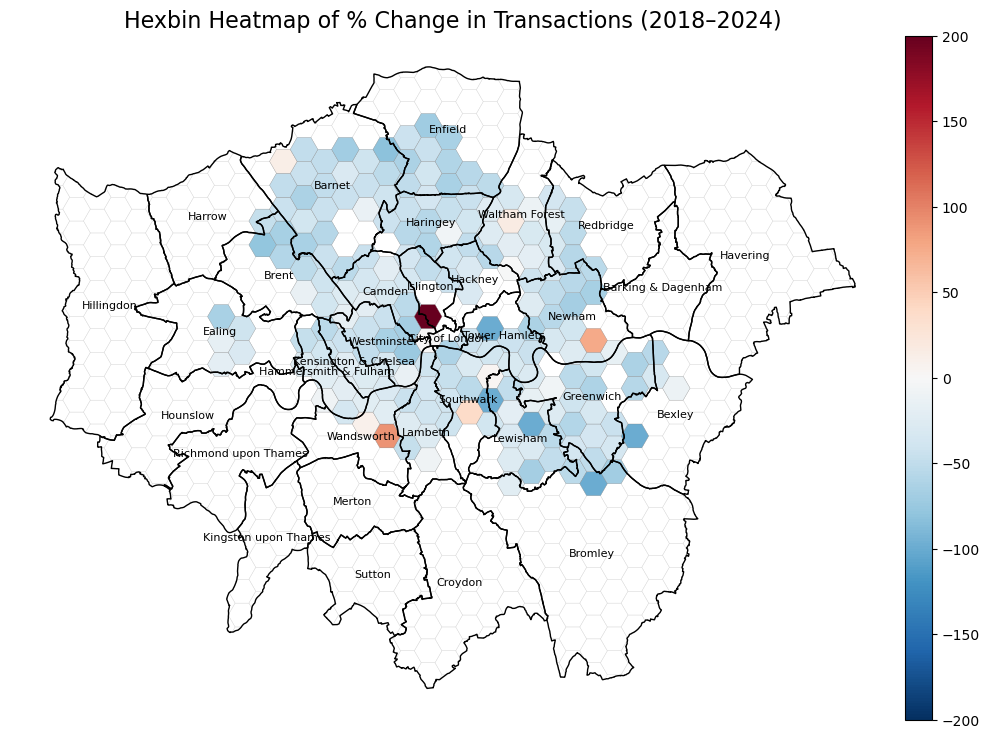

In [16]:
# Plot transactions heatmap
plot_transaction_heatmap(
    gdf=gdf,
    hexgrid=hexes,
    boroughs_path="./assets/London_Boroughs.shp",
    year=2018,
    hex_size=1000,
    cmap="coolwarm",
    mode = "delta"
)

c:\Users\nsant\Documents\price_paid_data_analysis\src\MappingUtils.py:283: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



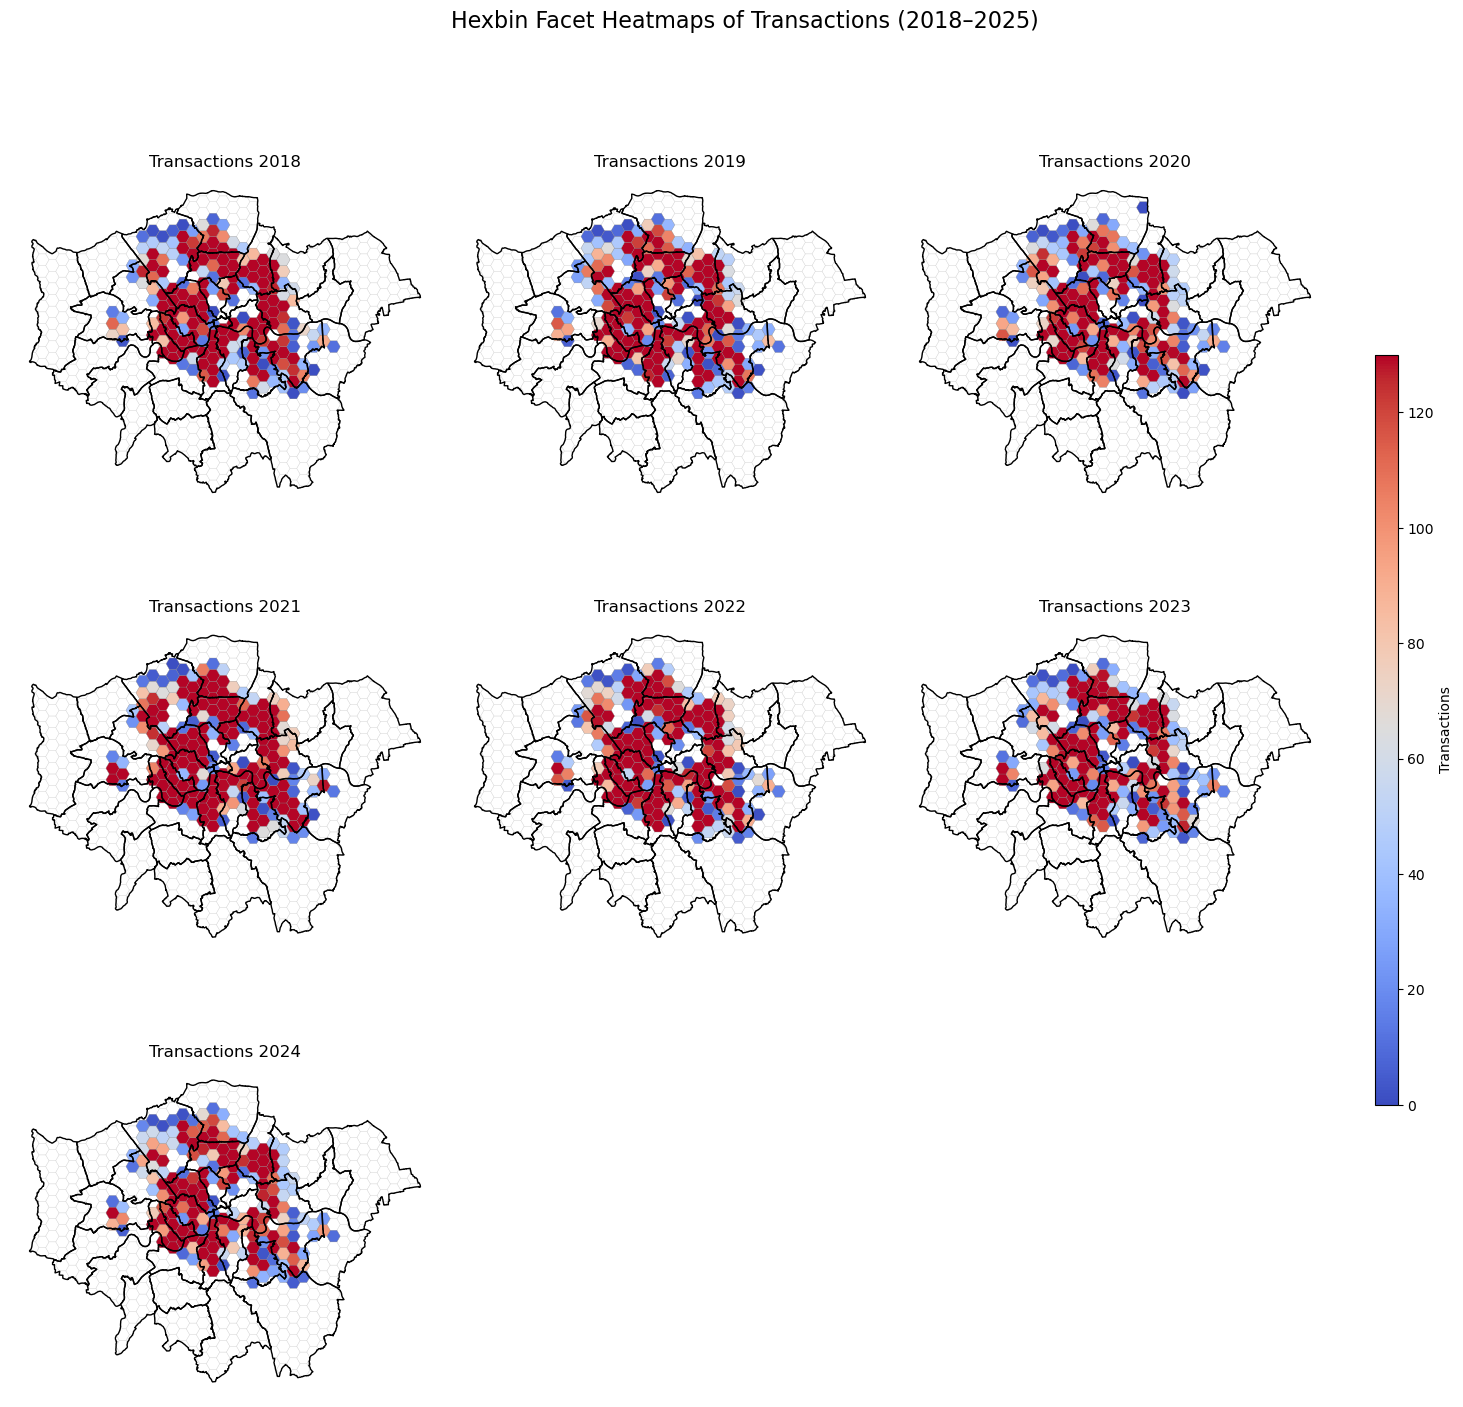

In [20]:
facet_transaction_heatmaps_by_year(
    gdf=gdf,
    hexgrid=hexes,
    boroughs_path="./assets/London_Boroughs.shp",
    years=range(2018, 2025),
    cols=3,
    cmap="coolwarm"
)

## 4) Modelling: predicting prices leveraging Auto ML thorugh AutoGluon library

No path specified. Models will be saved in: "AutogluonModels\ag-20250801_134455"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       6.94 GB / 15.42 GB (45.0%)
Disk Space Avail:   10.52 GB / 100.01 GB (10.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accur

[1000]	valid_set's rmse: 0.759202
[2000]	valid_set's rmse: 0.755383
[3000]	valid_set's rmse: 0.754102
[4000]	valid_set's rmse: 0.753783
[5000]	valid_set's rmse: 0.753563
[6000]	valid_set's rmse: 0.753238
[7000]	valid_set's rmse: 0.753084
[8000]	valid_set's rmse: 0.752759
[9000]	valid_set's rmse: 0.752453
[10000]	valid_set's rmse: 0.752155


	-0.752	 = Validation score   (-root_mean_squared_error)
	61.41s	 = Training   runtime
	0.63s	 = Validation runtime
Fitting model: LightGBM ...
	Fitting with cpus=8, gpus=0, mem=0.0/6.9 GB


[1000]	valid_set's rmse: 0.729816
[2000]	valid_set's rmse: 0.728146
[3000]	valid_set's rmse: 0.727212


	-0.7272	 = Validation score   (-root_mean_squared_error)
	70.17s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: RandomForestMSE ...
	Fitting with cpus=16, gpus=0, mem=0.2/7.1 GB
	-0.6727	 = Validation score   (-root_mean_squared_error)
	49.54s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=8, gpus=0
	-0.68	 = Validation score   (-root_mean_squared_error)
	394.4s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	Fitting with cpus=16, gpus=0, mem=0.2/7.3 GB
	-0.7145	 = Validation score   (-root_mean_squared_error)
	33.18s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	Fitting with cpus=8, gpus=0, mem=0.1/6.5 GB
		Import fastai failed. A quick tip is to install via `pip install autogluon.tabular[fastai]==1.4.0`. 
Fitting model: XGBoost ...
	Fitting with cpus=8, gpus=0
		`import xgboost` failed. A quick tip is to install via `pip install autogluon

[1000]	valid_set's rmse: 0.728059


	-0.7274	 = Validation score   (-root_mean_squared_error)
	90.3s	 = Training   runtime
	0.66s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'RandomForestMSE': 0.533, 'CatBoost': 0.467}
	-0.6463	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 711.16s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 18421.4 rows/s (3857 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\nsant\Documents\price_paid_data_analysis\AutogluonModels\ag-20250801_134455")


                 model  score_test  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   -0.610352  -0.646341  root_mean_squared_error        1.532996       0.209376  443.962396                 0.016560                0.000000           0.021506            2       True          7
1             CatBoost   -0.637225  -0.679981  root_mean_squared_error        0.322837       0.120067  394.400374                 0.322837                0.120067         394.400374            1       True          4
2      RandomForestMSE   -0.638344  -0.672656  root_mean_squared_error        1.193599       0.089309   49.540516                 1.193599                0.089309          49.540516            1       True          3
3        ExtraTreesMSE   -0.661412  -0.714549  root_mean_squared_error        1.072426       0.089491   33.182243                 1.

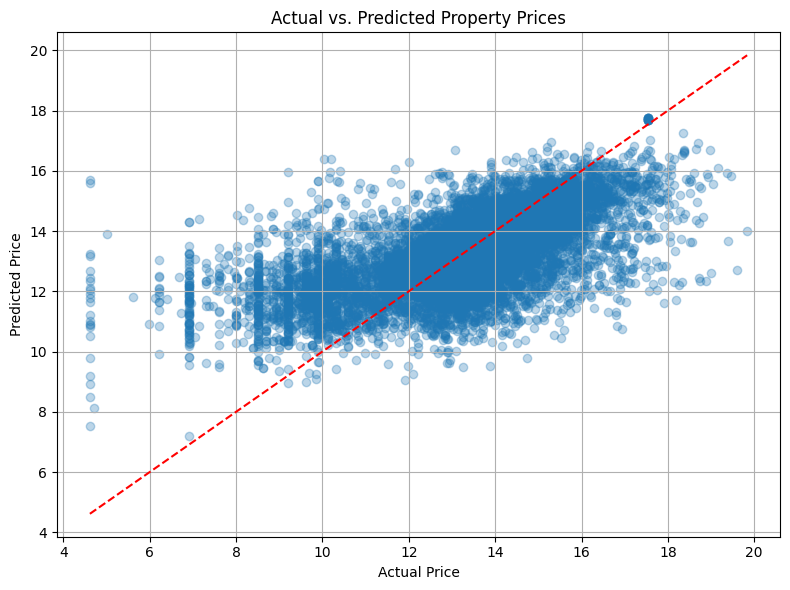

In [7]:
# Target Y: price
# Features X: year, month, property_type, post_code_area, old_new, duration, district, duration
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


# Extract postcode area
london_df['post_code_area'] = london_df['postcode'].str.extract(r'^([A-Z]+\d*)')

# Apply log transformation
london_df['price_log'] = np.log1p(london_df['price'])  # log1p handles 0s safely

# Select relevant columns and drop missing values
df = london_df[['price_log', 'year', 'month', 'property_type', 'postcode', 'old_new', 'duration', 'district']].dropna()

# Ensure categorical types 
categorical_cols = ['property_type', 'postcode', 'old_new', 'duration', 'district']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Split into train/test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Train model
predictor = TabularPredictor(label='price_log').fit(train_data=train_data)

# Leaderboard (evaluates on test set if provided)
print(predictor.leaderboard(test_data, silent=False))

# Evaluate performance on test set
performance = predictor.evaluate(test_data)

# Manual metrics (optional)
y_true = test_data['price_log']
y_pred = predictor.predict(test_data)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nManual Evaluation Metrics:\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Property Prices")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()
